# test 3


In [106]:
import re,os,glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import statistics
from collections import defaultdict
import numpy as np
# re patterns
base_save_dir="results/throughput/"
base_save_dir_thesis="../latex/results/"
base_dir=os.path.join("data/throughput/last")

file_pattern= r'(\w+)_(\w+)_tT(\d+)_(\d+).data'
matching_files = glob.glob(f"{base_dir}/*")

pub_pattern = r'cycles: (\d+) instruction: (\d+) start_ns: (\d+) end_ns: (\d+) start_s: (\d+) end_s: (\d+)'
sub_pattern = r'(\d+) received_s: (\d+) received_ns: (\d+)'

protocols=["udp","udpM","shm","tcp"]
sequence=[1,5,10,15,20,25,30,35,40]

# Calculate the IQR
def calculate_iqr(data):
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

def timespec_difference(start_s, start_ns, end_s, end_ns):
    time1_merged= start_s *1e6 + start_ns / 1e3
    time2_merged= end_s *1e6 + end_ns / 1e3
    return (time2_merged - time1_merged)




## Retrive data

In [107]:
sent_data={}
received_negative={}
received_data={}
sent_data_time={}
for prot in protocols:
    sent_data[prot]={}
    received_data[prot]={}
    sent_data_time[prot]={}
    for seq in sequence:
        sent_data[prot][seq]=[]
        received_data[prot][seq]=[]
        sent_data_time[prot][seq]=[]

for files in matching_files:
    match_file = re.search(file_pattern, files)
    if match_file:
        actor,protocol,testN,subIndex = match_file.groups()
        if actor == "pub": #pubs
            with open(files, 'r') as file: 
                for line in file:
                    match = re.search(pub_pattern, line)
                    if match:
                        cycles, instruction, start_ns, end_ns, start_s, end_s = match.groups()
                        sent_data[protocol][int(testN)].append((int(cycles), int(instruction), int(start_s), int(start_ns), int(end_s), int(end_ns)))
                        diff = timespec_difference(int(start_s), int(start_ns) , int(end_s) ,int(end_ns) )
                        sent_data_time[protocol][int(testN)].append(diff)
                    else: print("NOT MATCH PUB")
        else: # subs
            with open(files, 'r') as file: 
                for content in file:
                    match = re.search(sub_pattern, content)
                    if match:
                        line_n, received_s, received_ns = match.groups()
                        start_s,start_ns = ((sent_data[protocol][int(testN)][int(line_n)][2], sent_data[protocol][int(testN)][int(line_n)][3]))
                        diff = timespec_difference(start_s, start_ns , int(received_s), int(received_ns)) / 2
                        received_data[protocol][int(testN)].append(diff)


### Cleaning data

In [108]:
column_time_avg ={}
column_time_cleaned = {}
column_timesent_avg ={}
column_timesent_cleaned = {}
for prots in protocols:
    column_time_cleaned[prots]={}
    column_time_avg[prots]={}
    column_timesent_cleaned[prots]={}
    column_timesent_avg[prots]={}
    for seq in sequence:
        try:
            lower_bound, upper_bound = calculate_iqr(received_data[prots][seq])
            column_time_cleaned[prots][seq] = [x for x in received_data[prots][seq] if lower_bound <= x <= upper_bound]
            column_time_avg[prots][seq]=np.average(column_time_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass
    for seq in sequence:
        try:
            lower_bound, upper_bound = calculate_iqr(sent_data_time[prots][seq])
            column_timesent_cleaned[prots][seq] = [x for x in sent_data_time[prots][seq] if lower_bound <= x <= upper_bound]
            column_timesent_avg[prots][seq]=np.average(column_timesent_cleaned[prots][seq])
            #print(column_time_avg[prots][seq])
        except: pass


# Sending-receive

### Sequence 1: only 1 pub 1 sub

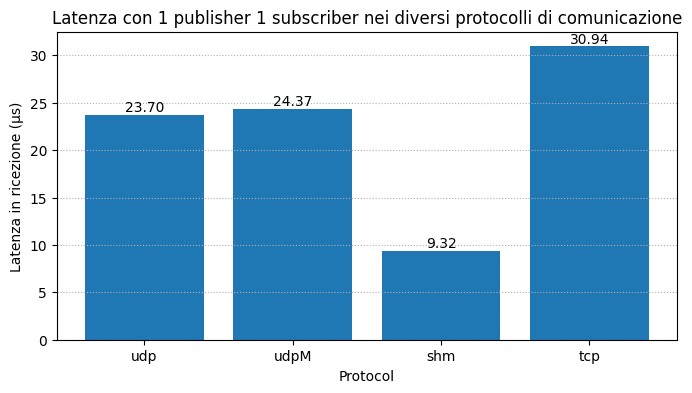

In [124]:
sequence_to_compare = 1
data_to_compare = {prots: column_time_cleaned[prots][sequence_to_compare] for prots in protocols}

average_times = [np.mean(data_to_compare[prots]) for prots in protocols]

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
bars = ax.bar(protocols, average_times)

for bar, value in zip(bars, average_times):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.05, f'{value:.2f}', ha='center', va='bottom')

ax.set_xlabel('Protocol')
ax.set_ylabel('Latenza in ricezione (μs)')
ax.set_title(f'Latenza con 1 publisher 1 subscriber nei diversi protocolli di comunicazione')
plt.savefig(f"{base_save_dir_thesis}test1_bar_sr_1p1s.png")
plt.savefig(f"{base_save_dir}test1_bar_sr_1p1s.png")
plt.grid(axis='y', linestyle=':')

plt.show()


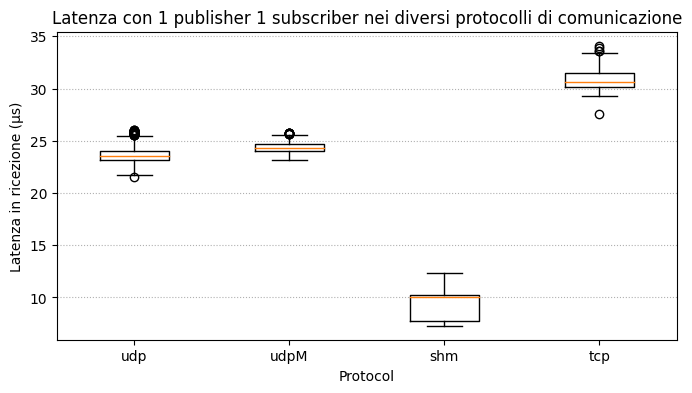

In [127]:
data_to_compare = {prots: column_time_cleaned[prots][sequence_to_compare] for prots in protocols}

data_list = [data_to_compare[prots] for prots in protocols]

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
ax.boxplot(data_list, labels=protocols)
ax.set_xlabel('Protocol')
ax.set_ylabel('Latenza in ricezione (μs)')



### All sequence

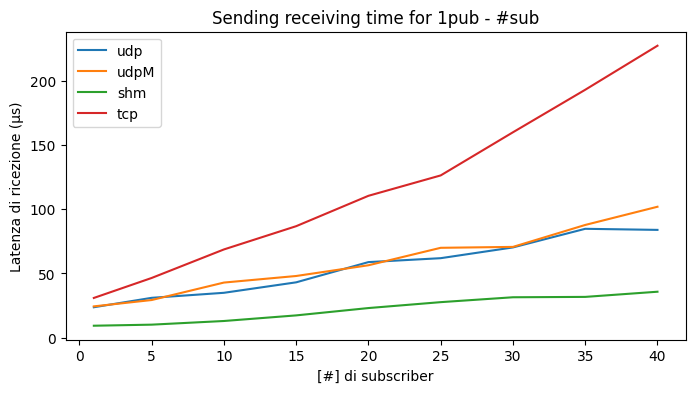

In [111]:
avg_data = {prots: [column_time_avg[prots][seq] for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)

for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('[#] di subscriber')
ax.set_ylabel('Latenza in ricezione (μs)')
ax.legend()
plt.savefig(f"{base_save_dir_thesis}test3_sendingreceiving_multiplesub.png")
ax.set_title('Sending receiving time for 1pub - #sub')
plt.savefig(f"{base_save_dir}test3_sendingreceiving_multiplesub.png")


plt.show()

### udp vs udpM

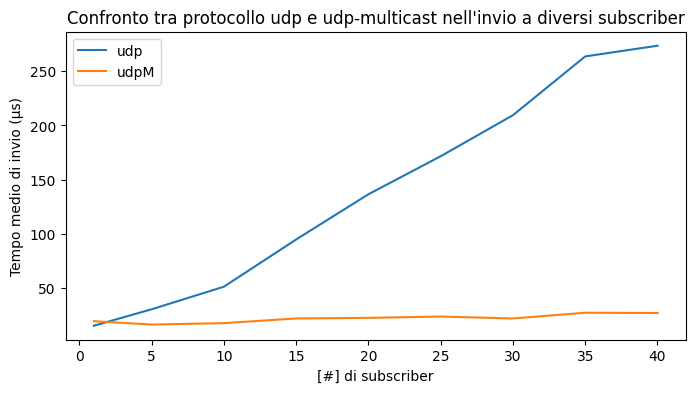

In [112]:
avg_data = {prots: [column_timesent_avg[prots][seq] for seq in sequence] for prots in ["udp","udpM"]}

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
for prots in ["udp","udpM"]:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('[#] di subscriber')
ax.set_ylabel('Tempo medio di invio (μs)')
ax.legend()
ax.set_title('Confronto tra protocollo udp e udp-multicast nell\'invio a diversi subscriber')
plt.savefig(f"{base_save_dir_thesis}test3_udpvsudpM.png")


plt.savefig(f"{base_save_dir}test3_udpvsudpM.png")



plt.show()

# Only send


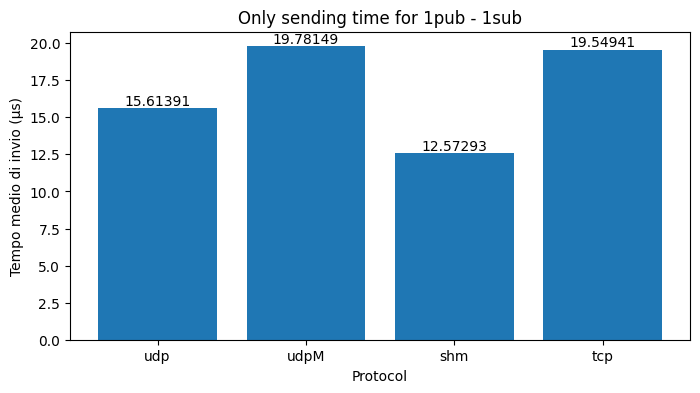

In [113]:
sequence_to_compare = 1
data_to_compare = {prots: column_timesent_cleaned[prots][sequence_to_compare] for prots in protocols}

average_times = [np.mean(data_to_compare[prots]) for prots in protocols]

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
bars = ax.bar(protocols, average_times)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.5f}', ha='center', va='bottom')

ax.set_xlabel('Protocol')
ax.set_ylabel('Tempo medio di invio (μs)')
plt.savefig(f"{base_save_dir_thesis}test3_sending_1sub.png")
ax.set_title(f'Only sending time for 1pub - 1sub')
plt.savefig(f"{base_save_dir}test3_sending_1sub.png")



plt.show()

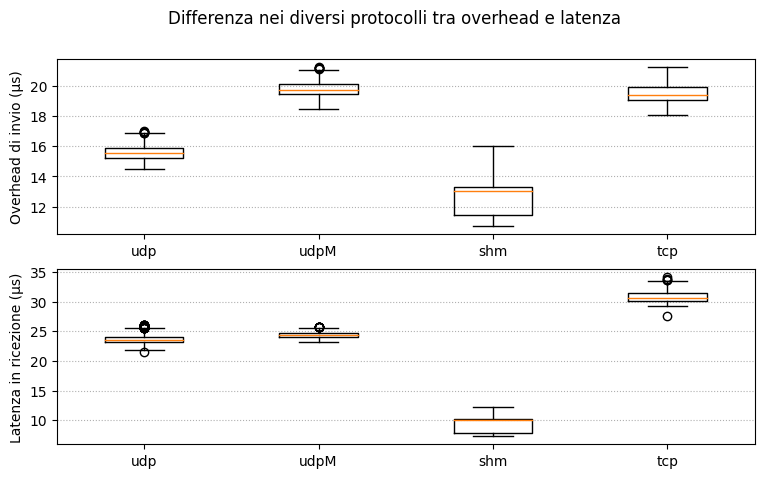

In [143]:
# data_to_compare = {prots: column_timesent_cleaned[prots][sequence_to_compare] for prots in protocols}

# data_list = [data_to_compare[prots] for prots in protocols]

# fig, ax = plt.subplots()

# ax.boxplot(data_list, labels=protocols)
# ax.set_xlabel('Protocol')
# ax.set_ylabel('Time (μs)')
# ax.set_title(f'Only sending time for 1pub - 1sub {sequence_to_compare}')
# plt.show()        

sequence_to_compare=1
fig, axs = plt.subplots(2, figsize=(9, 5))
fig.suptitle('Differenza nei diversi protocolli tra overhead e latenza')

data_to_compare = {prots: column_timesent_cleaned[prots][sequence_to_compare] for prots in protocols}
data_list = [data_to_compare[prots] for prots in protocols]
# Box plot for cycles
axs[0].boxplot(data_list,labels=protocols)
axs[0].set_ylabel('Overhead di invio (μs)')
axs[0].grid(axis='y', linestyle=':')

data_to_compare = {prots: column_time_cleaned[prots][sequence_to_compare] for prots in protocols}
data_list = [data_to_compare[prots] for prots in protocols]
# Box plot for instructions
axs[1].boxplot(data_list,labels=protocols)
axs[1].set_ylabel('Latenza in ricezione (μs)')

ax.set_title(f'Latenza con 1 publisher 1 subscriber nei diversi protocolli di comunicazione')
plt.savefig(f"{base_save_dir_thesis}test1_box_sr_1p1s.png")
plt.savefig(f"{base_save_dir}test1_box_sr_1p1s.png")
plt.grid(axis='y', linestyle=':')


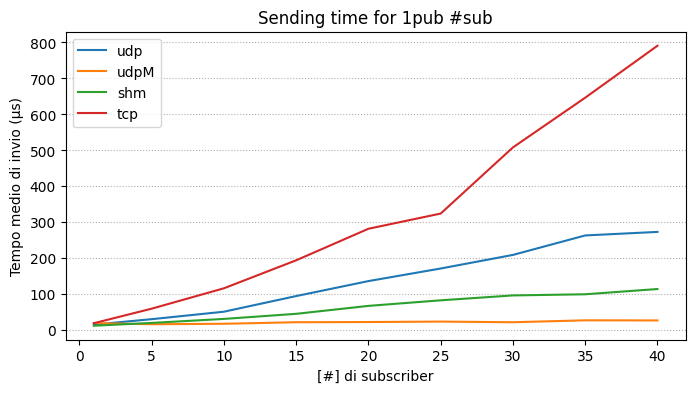

In [115]:
avg_data = {prots: [column_timesent_avg[prots][seq] for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('[#] di subscriber')
ax.set_ylabel('Tempo medio di invio (μs)')
ax.legend()
plt.grid(axis='y', linestyle=':')
plt.savefig(f"{base_save_dir_thesis}test3_sending_multiplesub.png")
ax.set_title('Sending time for 1pub #sub')
plt.savefig(f"{base_save_dir}test3_sending_multiplesub.png")



plt.show()

# Protocol in-depth analysis

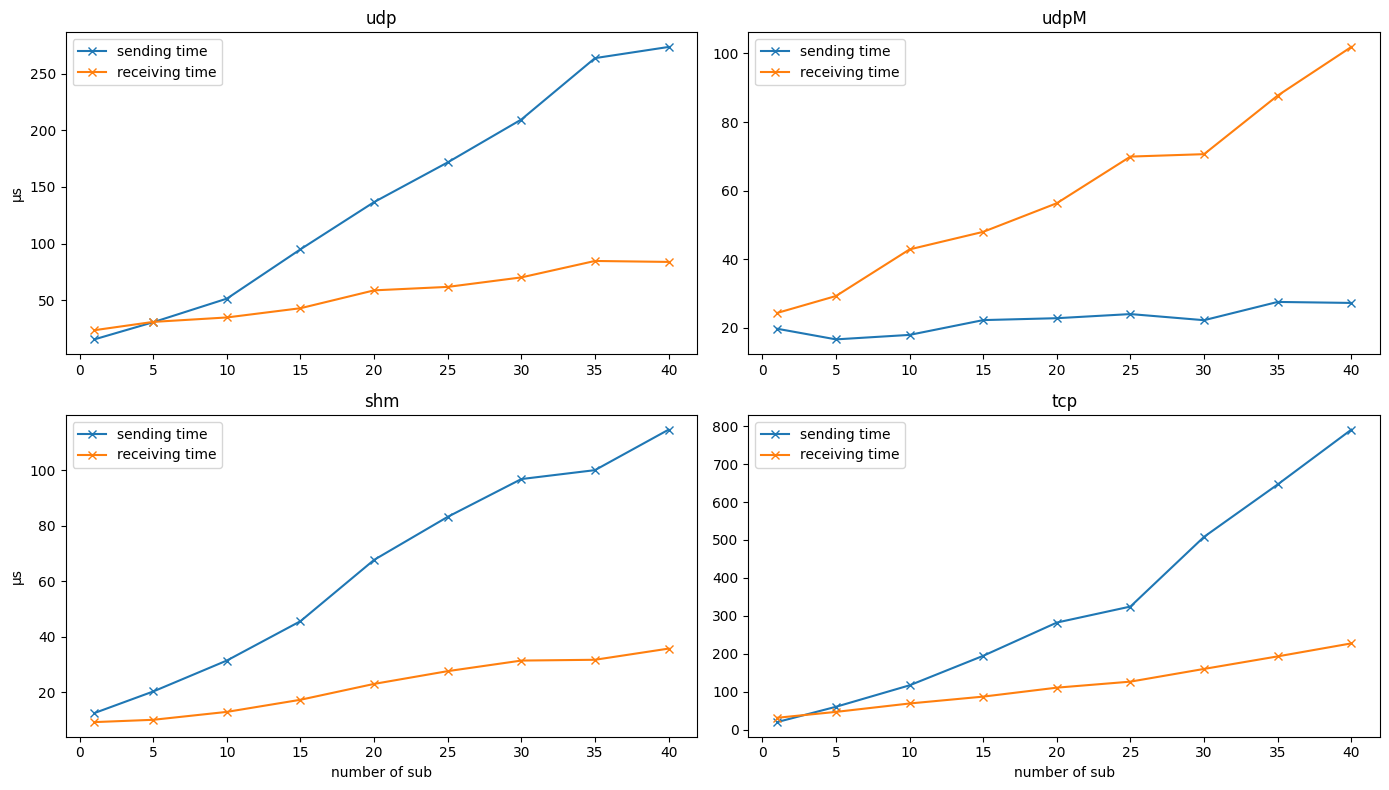

In [116]:
sent_avg={}
time_avg={}

for prot in protocols:
    sent_avg[prot] = [column_timesent_avg[prot][seq] for seq in sequence]
    time_avg[prot] = [column_time_avg[prot][seq] for seq in sequence]

fig = plt.figure(figsize=(14, 8))
gs = gridspec.GridSpec(2, 2)
for i,prot in enumerate(protocols):
    ax = plt.subplot(gs[i])
    ax.set_title(prot)
    ax.plot(sequence, sent_avg[prot], label='sending time', marker='x')
    ax.plot(sequence, time_avg[prot], label='receiving time', marker='x')
    if(i==2 or i== 3): ax.set_xlabel('number of sub')
    if(prot== "shm" or prot == "udp"): ax.set_ylabel('μs')
    ax.legend()

plt.savefig(f"{base_save_dir}test3_different_protocol_send_receive.png")
plt.savefig(f"{base_save_dir_thesis}test3_different_protocol_send_receive.png")


plt.tight_layout()
plt.show()

# Troughput

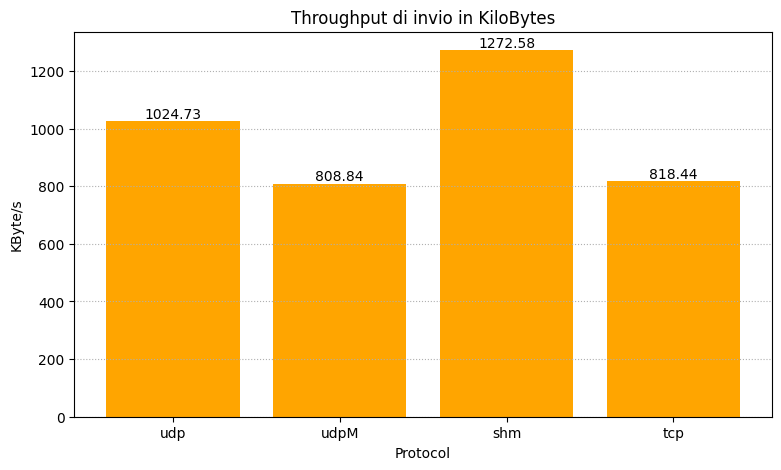

In [145]:

throughput_send={}
throughput_receive={}
for prot in protocols:
    throughput_send[prot]=      1/column_timesent_avg[prot][1] * 1e6 * 1 * 16 / 1e3 # it was on microseconds but witk K
    throughput_receive[prot] =  1/column_time_avg[prot][1] * 1e6 * 1 * 16 / 1e3 # it was on microseconds but with K

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot()
ax.set_xlabel('Protocol')
ax.set_ylabel('KByte/s')

data_to_compare = {prots: throughput_send[prots] for prots in protocols}
average_times = [np.mean(data_to_compare[prots]) for prots in protocols] 
bars = ax.bar(protocols, average_times,color="orange")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.grid(axis='y', linestyle=':')
ax.set_title(f'Throughput di invio in KiloBytes/s')
plt.savefig(f"{base_save_dir_thesis}test3_throughput.png")
#ax.set_title(f'Sending Throughput')
plt.savefig(f"{base_save_dir}test3_throughput.png")


plt.show()

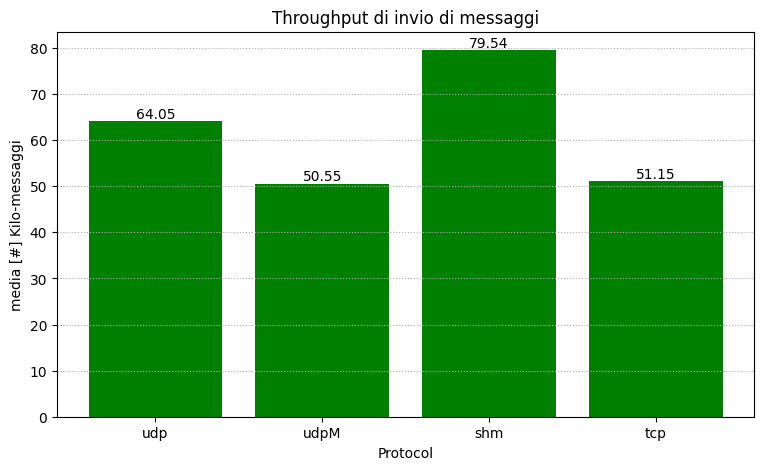

In [118]:
#Messages 
for prot in protocols:
    throughput_send[prot]=      1/column_timesent_avg[prot][1]  * 1e6 / 1e3  # it was on microseconds but witk K
    throughput_receive[prot] =  1/column_time_avg[prot][1]      * 1e6 / 1e3  # it was on microseconds but with K

fig = plt.figure(figsize=(9, 5))
ax = plt.subplot()
ax.set_xlabel('Protocol')
ax.set_ylabel('media [#] Kilo-messaggi')

data_to_compare = {prots: throughput_send[prots] for prots in protocols}
average_times = [np.mean(data_to_compare[prots]) for prots in protocols] 
bars = ax.bar(protocols, average_times,color="green")
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.grid(axis='y', linestyle=':')
ax.set_title(f'Throughput di invio di KiloMessaggi/s')

plt.savefig(f"{base_save_dir_thesis}test3_throughput_m.png")
plt.savefig(f"{base_save_dir}test3_throughput_m.png")


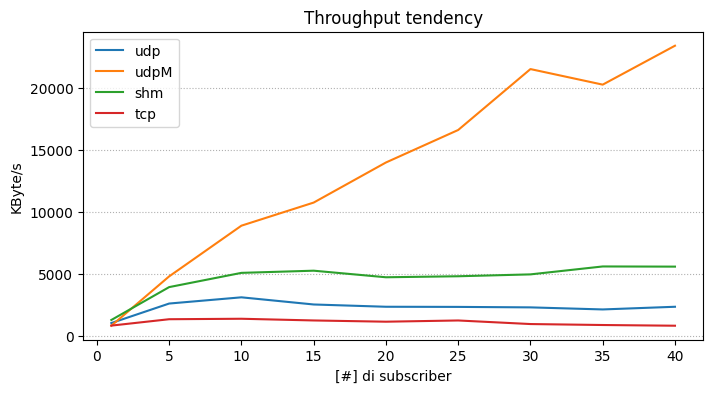

In [119]:
avg_data = {prots: [ 1 / column_timesent_avg[prots][seq] * 1e6 * seq * 16 / 1e3 for seq in sequence] for prots in protocols}

fig, ax = plt.subplots()
fig.set_figheight(4)
fig.set_figwidth(8)
for prots in protocols:
    ax.plot(sequence, avg_data[prots], label=prots)
ax.set_xlabel('[#] di subscriber')
ax.set_ylabel('KByte/s')
ax.legend()
plt.grid(axis='y', linestyle=':')
plt.savefig(f"{base_save_dir_thesis}test3_graph_throughput.png")
ax.set_title('Throughput tendency')
plt.savefig(f"{base_save_dir}test3_graph_throughput.png")


## Instruction vs TSC

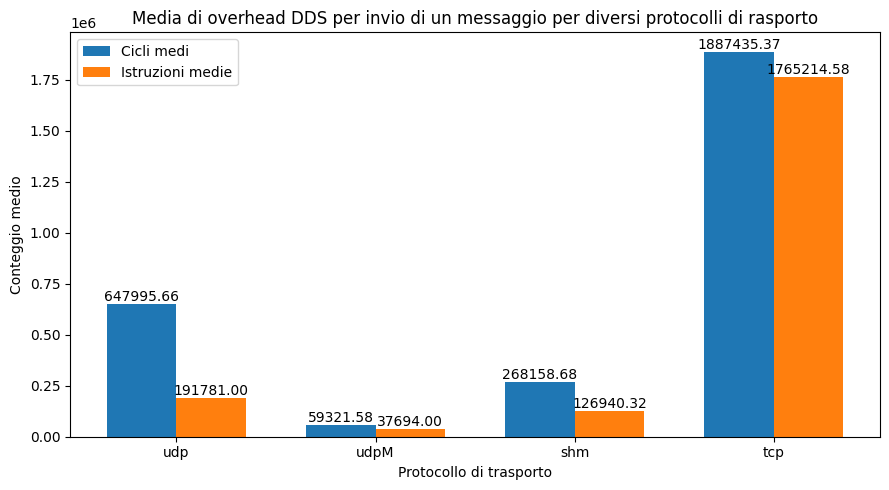

In [144]:
cycles,cycles_cleaned,instructions_cleaned={},{},{}
instructions={}
average_cycles={}
average_instructions={}

for prot in protocols:
    cycles[prot] = [data[0] for data in sent_data[prot][40]]
    instructions[prot] = [data[1] for data in sent_data[prot][40]]
    lower_bound, upper_bound = calculate_iqr(cycles[prot])
    cycles_cleaned[prot] = [x for x in cycles[prot] if lower_bound <= x <= upper_bound]
    lower_bound, upper_bound = calculate_iqr(instructions[prot])
    instructions_cleaned[prot] = [x for x in instructions[prot] if lower_bound <= x <= upper_bound]
    average_cycles[prot] = sum(cycles_cleaned[prot]) / len(cycles_cleaned[prot])
    average_instructions[prot] = sum(instructions_cleaned[prot]) / len(instructions_cleaned[prot])

fig, ax = plt.subplots(figsize=(9, 5))
bar_width = 0.35
x = range(len(protocols))
barsc = plt.bar(x, average_cycles.values(), width=bar_width, label='Cicli medi')
barsi=plt.bar([i + bar_width for i in x], average_instructions.values(), width=bar_width, label='Istruzioni medie')
plt.xticks([i + bar_width / 2 for i in x], protocols)
plt.xlabel('Protocollo di trasporto')
plt.ylabel('Conteggio medio')
for bar in barsc:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in barsi:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')
plt.title("Average cycles and instruction vs different protocols")
plt.legend()
plt.tight_layout()

plt.savefig(f"{base_save_dir_thesis}test1_cyclinstr.png")
ax.set_title(f'Media di overhead DDS per invio di un messaggio per diversi protocolli di rasporto')
plt.savefig(f"{base_save_dir}test1_cyclinstr.png")

#Label: numero di cicli e istruzioni necessari per inviare 1 messaggio in diversi protcolli. 
plt.show()

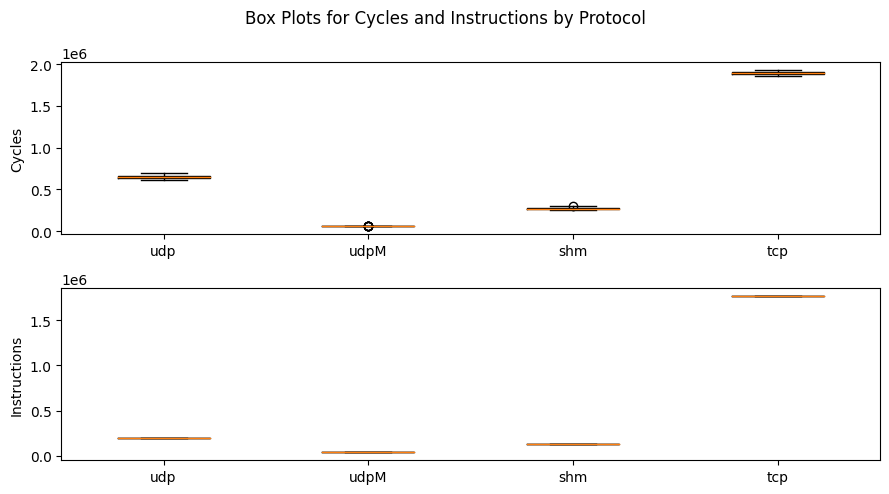

In [121]:
fig, axs = plt.subplots(2, figsize=(9, 5))
fig.suptitle('Box Plots for Cycles and Instructions by Protocol')

# Box plot for cycles
axs[0].boxplot(cycles_cleaned.values())
axs[0].set_xticklabels(cycles_cleaned.keys())
axs[0].set_ylabel('Cycles')

# Box plot for instructions
axs[1].boxplot(instructions_cleaned.values())
axs[1].set_xticklabels(instructions_cleaned.keys())
axs[1].set_ylabel('Instructions')

plt.tight_layout()
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


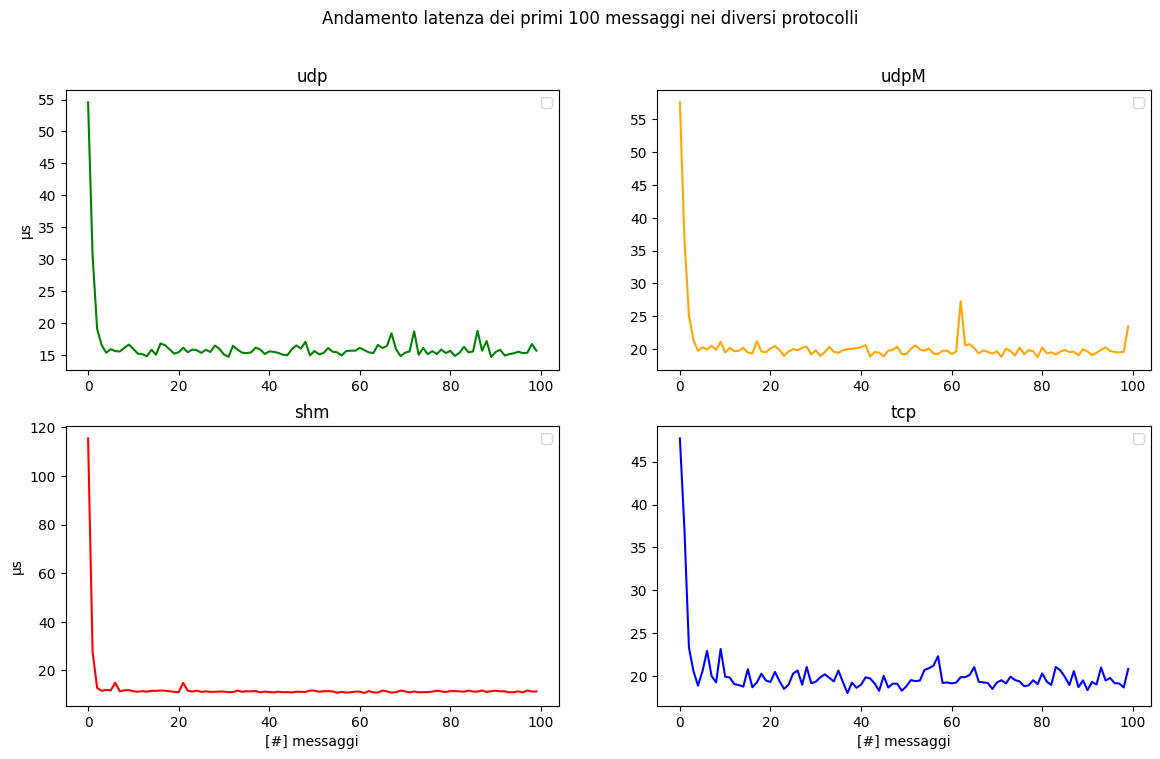

In [122]:
# fig, ax = plt.subplots( figsize=(9, 5))
# avg_data = {prots: [sent_data_time[prots][seq] for seq in [5]] for prots in protocols}
# plt.xlabel('[#] messagi')
# plt.ylabel('Latenza in ricezione del messaggio (μs)')
# for prot in protocols:
#     plt.plot(sent_data_time[prot][1][:100])
# plt.title("Andamento latenza dei primi 100 messaggi nei diversi protocolli")

colors=["green","orange","red","blue"]
fig = plt.figure(figsize=(14, 8))
fig.suptitle("Andamento latenza dei primi 100 messaggi nei diversi protocolli")
gs = gridspec.GridSpec(2, 2)
for i,prot in enumerate(protocols):
    ax = plt.subplot(gs[i])
    ax.set_title(prot)
    ax.plot(sent_data_time[prot][1][:100],color=colors[i])
    if(i==2 or i== 3): ax.set_xlabel('[#] messaggi')
    if(prot== "shm" or prot == "udp"): ax.set_ylabel('μs')
    ax.legend()


plt.savefig(f"{base_save_dir_thesis}errortest.png")
plt.savefig(f"{base_save_dir}errortest.png")